# Transfer learning with MobileNet

In [1]:
#MobileNet
#NASNetMobile
#InceptionV3

import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

2024-04-26 20:36:57.639006: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 20:36:57.964973: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 20:36:57.965017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 20:36:58.038557: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 20:36:58.189415: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 20:36:58.191798: I tensorflow/core/platform/cpu_feature_guard.cc:1

Found 1003 files belonging to 2 classes.
Using 803 files for training.
Using 200 files for validation.


2024-04-26 20:37:02.436303: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 20:37:02.436699: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


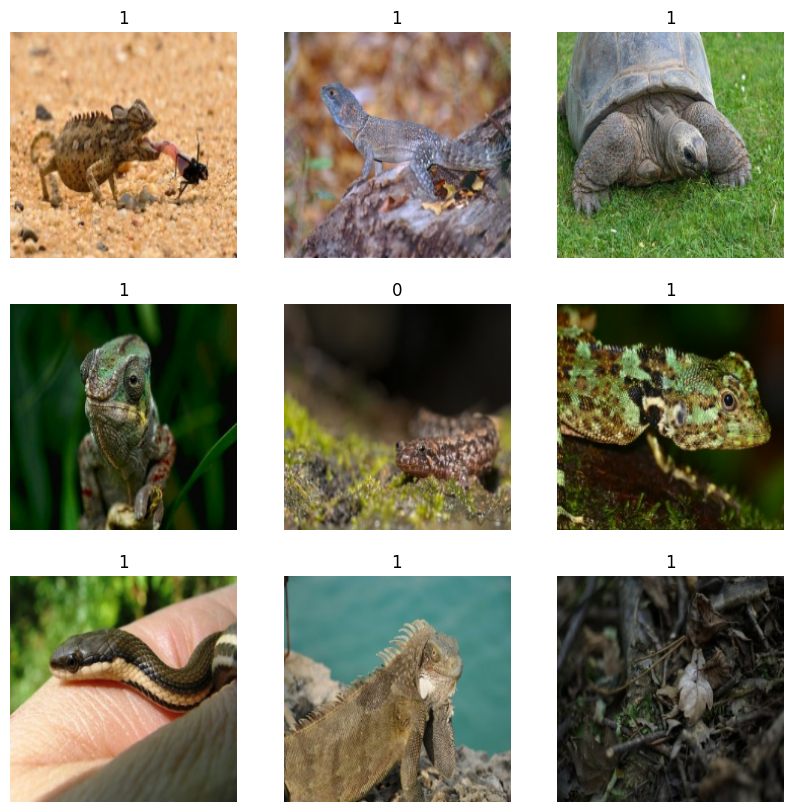

In [2]:
import DataLoader

train_ds, val_ds = DataLoader.load_image_dataset("reptile_amphibian_pics")

DataLoader.show_images(train_ds)


In [3]:
from keras.applications import MobileNet
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
import keras
from keras import layers

def make_transfer_model(input_shape, num_classes):
    # Load the pre-trained weights of MobileNet and freeze the weights
    backbone = keras.applications.MobileNet(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False

    # input layer and mobilenet backbone and dropout
    inputs = layers.Input(input_shape)
    x = keras.applications.mobilenet.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)

    # global average pooling layer
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    # another dropout
    x = layers.Dropout(0.25)(x)

    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)

    # Define the model
    model = keras.Model(inputs, outputs, name="transfer_model")

    return model

# Create the transfer model
image_size = (224, 224)
model = make_transfer_model(input_shape=image_size + (3,), num_classes=2)



In [4]:
epochs =10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.legacy.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
81/81 [==============================] - 9s 97ms/step - loss: 0.7223 - acc: 0.5729 - val_loss: 0.4791 - val_acc: 0.7700
Epoch 2/10
81/81 [==============================] - 7s 91ms/step - loss: 0.5372 - acc: 0.7173 - val_loss: 0.3893 - val_acc: 0.8250
Epoch 3/10
81/81 [==============================] - 7s 89ms/step - loss: 0.4342 - acc: 0.7821 - val_loss: 0.3378 - val_acc: 0.8650
Epoch 4/10
81/81 [==============================] - 8s 94ms/step - loss: 0.3587 - acc: 0.8369 - val_loss: 0.3091 - val_acc: 0.8850
Epoch 5/10
81/81 [==============================] - 8s 94ms/step - loss: 0.3286 - acc: 0.8506 - val_loss: 0.2901 - val_acc: 0.9000
Epoch 6/10
81/81 [==============================] - 8s 97ms/step - loss: 0.2894 - acc: 0.8792 - val_loss: 0.2780 - val_acc: 0.8900
Epoch 7/10
81/81 [==============================] - 8s 95ms/step - loss: 0.2723 - acc: 0.8966 - val_loss: 0.2679 - val_acc: 0.9000
Epoch 8/10
81/81 [==============================] - 8s 96ms/step - loss: 0.2496 - a

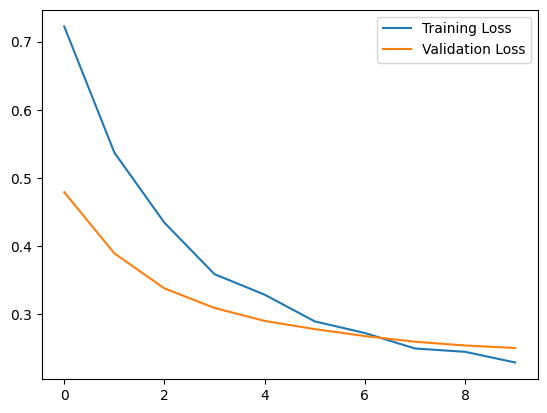

In [5]:

plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

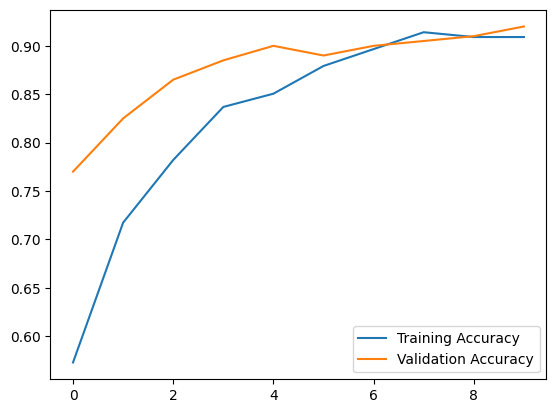

In [6]:

plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Accuracy")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Accuracy")
plt.legend()

In [12]:
# Save the model with keras
model.save("my_model.keras")

# Data Augmentation
+ Random Flip and Rotation from Dr.Farbin's example
+ Random Translation
+ Random Zoom

In [7]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), 
    layers.RandomZoom(height_factor=0.4, width_factor=0.4),]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

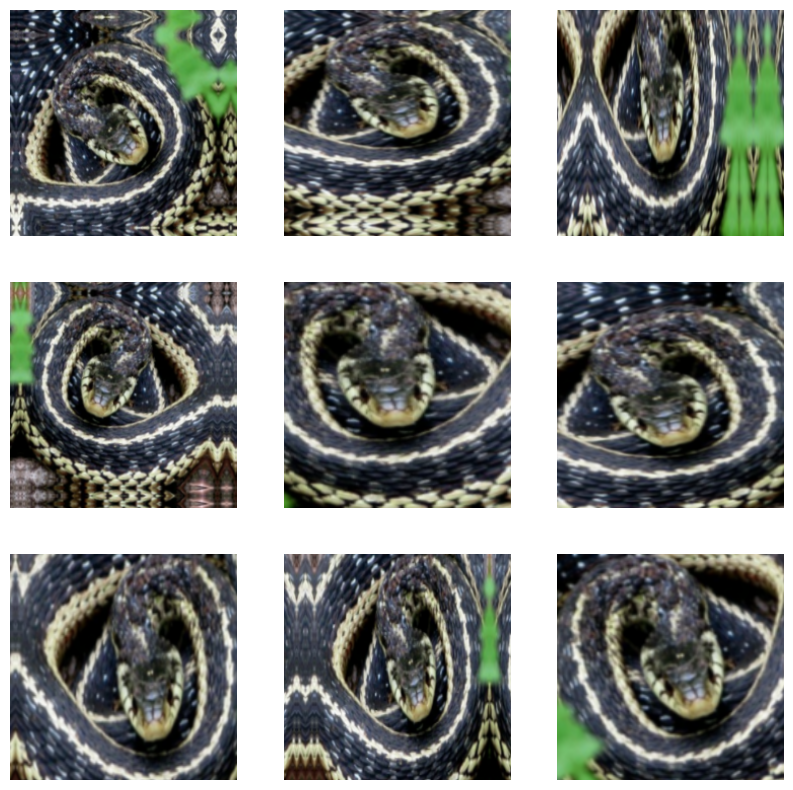

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [9]:
augmented_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
val_augmented_ds = val_ds.map(lambda x, y: (data_augmentation(x), y))

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model on augmented dataset
history = model.fit(augmented_ds, validation_data=val_augmented_ds, epochs=10)  # Adjust epochs as needed


Epoch 1/10
81/81 [==============================] - 15s 165ms/step - loss: 1.7699 - accuracy: 0.8580 - val_loss: 1.4295 - val_accuracy: 0.8750
Epoch 2/10
81/81 [==============================] - 13s 158ms/step - loss: 1.9615 - accuracy: 0.8418 - val_loss: 1.3184 - val_accuracy: 0.8600
Epoch 3/10
81/81 [==============================] - 13s 156ms/step - loss: 1.4203 - accuracy: 0.8730 - val_loss: 1.1938 - val_accuracy: 0.8950
Epoch 4/10
81/81 [==============================] - 13s 161ms/step - loss: 1.9814 - accuracy: 0.8232 - val_loss: 1.4752 - val_accuracy: 0.8650
Epoch 5/10
81/81 [==============================] - 28s 349ms/step - loss: 1.7417 - accuracy: 0.8481 - val_loss: 1.2035 - val_accuracy: 0.8850
Epoch 6/10
81/81 [==============================] - 38s 471ms/step - loss: 1.4679 - accuracy: 0.8655 - val_loss: 1.4455 - val_accuracy: 0.8750
Epoch 7/10
81/81 [==============================] - 13s 164ms/step - loss: 1.7775 - accuracy: 0.8580 - val_loss: 1.6638 - val_accuracy: 0.8650

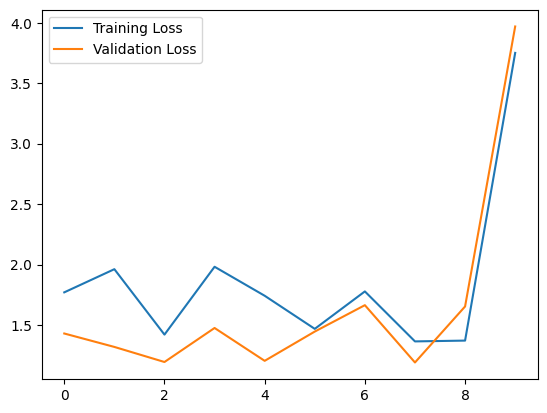

In [11]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

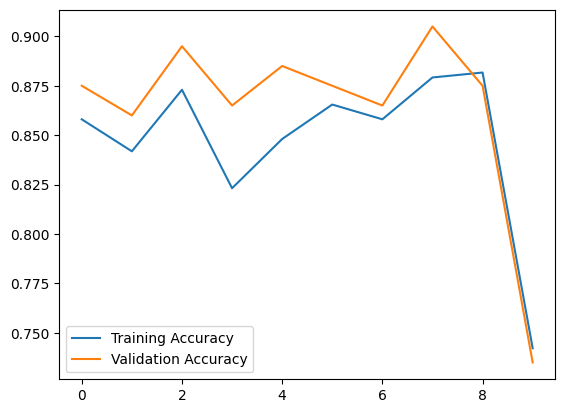

In [12]:
plt.plot(range(len(history.history["accuracy"])),history.history["accuracy"],label="Training Accuracy")
plt.plot(range(len(history.history["val_accuracy"])),history.history["val_accuracy"],label="Validation Accuracy")
plt.legend()

# Comparisons

**Model trained without augmented data**  
final training accuracy: 0.9091 and training loss: 0.2291
final val accuracy: 0.92 and val loss: 0.2504

+ This model has good accuracy and low loss values. It is performing very well.

**Model trained with augmented data**  
final training accuracy: 0.7422 and training loss: 3.7501
final val accuracy: 0.7350 and val loss: 3.9686

+ For this model the accuracy not that good. For some reason, the loss rises dramatically at the end while accuracy falls dramatically at the end. This indicates that the model is not fitting well to the dataset and I will need to do more hyperparameter tuning to the model.

The model trained on the original image dataset ended with a higher training accuracy as well as a lower loss value, indicating that without using augmented data for training, the transfer learning model performed better. 
